## LiteBIRD Mux Comb Simulation for Requirements

#### Tijmen de Haan -- 2023-08-11

In [3]:
import numpy as np
import copy
from matplotlib import pyplot as plt
from numba import jit
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib ipympl

ModuleNotFoundError: No module named 'numba'

Define a bolocomb class that can models a comb of LCR resonators. We will make a few simplifying assumptions. We assume 
 - DAN is working perfectly and we have perfect screening of any impedances in enclosed in the DAN loop.
 - each leg of the comb contains a simple LCR. All of the R is assumed to to be on the TES island. 
 - This comb of LCRs is in parallel with a resistor and capacitor which are a simplified model for all other current paths.
 - This combination is in series with some common series inductance and resistance.
 - This is biased using a finite bias element which for LiteBIRD is an inductor.

In [ ]:
@jit(nopython=True, nogil=True, cache=True)
def compute_z_thev(n_LCR, L, base_frequency, Rs, Rbias, Lbias, Ls, Cpar, Rpar, C, R):
    fmin = 1.5e6
    fmax = 5.6e6
    f = np.arange((fmin // base_frequency) * base_frequency, fmax, base_frequency)
    f_z_thev_purely_real = np.zeros(n_LCR)
    z_thev_optimal = np.zeros(n_LCR, dtype=np.complex64)
    z_s_inv = 1./(Rs + Rbias + 2.j * np.pi * f * Lbias + 2.j * np.pi * f * Ls)
    z_p_inv = 2.j * np.pi * f * Cpar + 1 / Rpar
    z_p_inv_per_leg = 1./(2.j * np.pi * f[:, np.newaxis] * L + R + 1./(2.j * np.pi * f[:, np.newaxis] * C))
    for i in range(n_LCR):
        this_z_p_inv = z_p_inv.copy()
        for j in range(n_LCR):
            if i != j:
                this_z_p_inv += z_p_inv_per_leg[:, j]
        this_z_LC = 2.j * np.pi * f * L + 1./(2.j * np.pi * f * C[i])
        this_z_thev = this_z_LC + 1./(z_s_inv + this_z_p_inv)
        wh_purely_real = np.argmin(np.abs(np.imag(this_z_thev)))
        f_z_thev_purely_real[i] = f[wh_purely_real]
        z_thev_optimal[i] = this_z_thev[wh_purely_real]

    return z_thev_optimal, f_z_thev_purely_real
    
class bolocomb:
    def __init__(self):
        self.L = 60e-6 # Inductance in Henries
        self.base_frequency = 20e6/2**18 # Base frequency in Hertz
        self.frequency_resolution = 20e6/2**30 # Frequency resolution in Hertz
        self.normalization = 100. # Normalization factor (arbitrary units)
        self.Rs = 0.005 # Stray series resistance in Ohms
        self.Ls = 30e-9 # Stray series inductance in Henries
        self.Cpar = 1500e-12 # Equivalent parasitic capacitance parallel to the comb in Farads
        self.Rpar = 20. # Equivalent parasitic resistance parallel to the comb in Ohms, 20 Ohms is what we find for the CIMM
        self.Rbias = 0. # Bias resistor in Ohms, this is zero for LiteBIRD
        self.Lbias = 5 * 1e-9 # Bias inductance in Henries
        self.C = np.array([100, 120]) * 1e-12 # LCR parameters for capacitance in Farads
        self.R = np.array([1, 1]) # LCR parameters for resistance in Ohms
        
    @property # property decorator ensures the n_LCR attribute is always up to date
    def n_LCR(self):
        return len(self.C)
    
    def admittance(self, f):
        jomega = 2.j * np.pi * f # Complex phase
        LRstray = self.Rs + jomega * self.Ls # Stray inductance and resistance
        LRbias = self.Rbias + jomega * self.Lbias # Bias inductance and resistance
        Larr = jomega * self.L # Inductance array
        Zinv = jomega * self.Cpar + 1 / self.Rpar # Inverse impedance for parallel components
        for C, R in zip(self.C, self.R):
            Zinv += 1./(Larr + 1./(jomega * C) + R)
        return self.normalization / (1. + (LRstray + 1./Zinv) / LRbias)
    
    def z_thev(self):
        return compute_z_thev(
            self.n_LCR, self.L, self.base_frequency, self.Rs, self.Rbias,
            self.Lbias, self.Ls, self.Cpar, self.Rpar, self.C, self.R)
    
    def xtalk(self):
        _,bias_freqs = self.z_thev()
        n_nearest_neighbor = self.n_LCR - 1
        nearest_neighbor_xtalk = np.zeros(n_nearest_neighbor, dtype=np.complex64)
        delta_R = 1e-3 # finite difference based on a 1 milliohm change
        for i in range(n_nearest_neighbor):
            this_frequency = bias_freqs[i]
            j = i+1
            Y_0 = self.admittance(this_frequency)
            self.R[i] += delta_R
            Y_i = self.admittance(this_frequency)
            self.R[i] -= delta_R
            self.R[j] += delta_R
            Y_j = self.admittance(this_frequency)
            self.R[j] -= delta_R
            nearest_neighbor_xtalk[i] = (Y_j-Y_0)/(Y_i-Y_0)
        return nearest_neighbor_xtalk

### Test the code by plotting up the default network analysis and printing the Thévenin equivalent impedances

In [ ]:
comb = bolocomb()
f = np.linspace(1e6,6e6,1000)
Y = comb.admittance(f)

plt.figure(figsize=(10,2))
plt.plot(f/1e6, np.abs(Y), label='Example bolocomb')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Admittance (arb.)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("There are {} peaks. Their Thévenin-equivalent impedances are {} Ohms.".format(comb.n_LCR, comb.z_thev()[0]))

### Build 68x combs in the uniformly spaced case and log-uniform case

In [ ]:
# Create two instances of the bolocomb class
bolocomb1 = bolocomb() # uniform spacing
bolocomb2 = bolocomb() # log-uniform spacing

# Number of LCR legs in the comb
num_legs = 68

# Resistance values for both instances
R = 0.7 # all resistance values around 0.7 Ohms
R_values = np.ones(num_legs)*R
R_values += np.random.normal(0, 0.1, num_legs) * R # 100 mOhm scatter in R

# Inductance value (from the bolocomb class)
L_value = bolocomb1.L

# For the first instance, create LCR legs uniformly distributed between 1.6 and 5.5 MHz
frequencies_uniform = np.linspace(1.6e6, 5.5e6, num_legs) + np.random.uniform(-5e3, 5e3, num_legs) # +/- 5 kHz scatter
C_values_uniform = 1 / ((2 * np.pi * frequencies_uniform) ** 2 * L_value)
bolocomb1.C = C_values_uniform
bolocomb1.R = R_values

# For the second instance, create LCR legs uniformly distributed in log frequency between 1.6 and 5.5 MHz
frequencies_log = np.logspace(np.log10(1.6e6), np.log10(5.5e6), num_legs) + np.random.uniform(-5e3, 5e3, num_legs) # +/- 5 kHz scatter
C_values_log = 1 / ((2 * np.pi * frequencies_log) ** 2 * L_value)
bolocomb2.C = C_values_log
bolocomb2.R = R_values

#### Visualize their network analysis (admittance as a function of frequency)

In [ ]:
# Define a range of frequencies for which to calculate the admittance
frequencies = np.linspace(1e6, 6e6, 10000)

# Calculate the admittance for both combs over the frequency range
admittance1 = bolocomb1.admittance(frequencies)
admittance2 = bolocomb2.admittance(frequencies)

plt.figure(figsize=(10,5))
plt.plot(frequencies/1e6, np.abs(admittance1), label='Comb with uniform spacing')
plt.plot(frequencies/1e6, np.abs(admittance2), label='Comb with log-uniform spacing')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Admittance (arb.)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
_,bias_freqs = bolocomb1.z_thev()

In [ ]:
print(f"There are {len(bias_freqs)} peaks at {np.round(bias_freqs/1e6, 2)} MHz.")
rms_voltage = 0.8e-6
inductance = 5e-9
currents = rms_voltage/(2*np.pi*bias_freqs*inductance)
rms_current = np.sqrt((currents**2).sum())
print(f"The RMS current is {np.round(rms_current*1e6, 2)} uA.")


### Explore uniform vs log-uniform

#### SPT-3G

For SPT-3G, we chose log-uniform resonator spacing. Let's look at why we made this choice. We will consider a comb which is ideal except for a common series inductance.

In [ ]:
# Create two instances of the bolocomb class
idealbolocomb1 = bolocomb() # linear spacing
idealbolocomb2 = bolocomb() # log spacing

idealbolocomb1.Rpar = idealbolocomb2.Rpar = 1e8 # assume there is basically infinite parallel resistance
idealbolocomb1.Cpar = idealbolocomb2.Cpar = 0e-12 # no parallel capacitance
idealbolocomb1.Rs = idealbolocomb2.Rs = 0 # no common series resistance
idealbolocomb1.Ls = idealbolocomb2.Ls = 100e-9 # significant common series inductance
idealbolocomb1.Lbias = idealbolocomb2.Lbias = 0.1e-9 # small bias element
idealbolocomb1.Rbias = idealbolocomb2.Rbias = 0.0

# Number of LCR legs in the comb
num_legs = 68

# Resistance values for both instances
R = 2 # all resistance values around 0.5 Ohms
R_values = np.ones(num_legs)*R # no scatter in R

# Inductance value (from the bolocomb class)
L_value = bolocomb1.L

# For the first instance, create LCR legs uniformly distributed between 1.6 and 5.5 MHz
frequencies_uniform = np.linspace(1.6e6, 5.5e6, num_legs) # no scatter in frequency
C_values_uniform = 1 / ((2 * np.pi * frequencies_uniform) ** 2 * L_value)
idealbolocomb1.C = C_values_uniform
idealbolocomb1.R = R_values

# For the second instance, create LCR legs uniformly distributed in log frequency between 1.6 and 5.5 MHz
frequencies_log = np.logspace(np.log10(1.6e6), np.log10(5.5e6), num_legs) # no scatter in frequency
C_values_log = 1 / ((2 * np.pi * frequencies_log) ** 2 * L_value)
idealbolocomb2.C = C_values_log
idealbolocomb2.R = R_values

z_thev1,_ = idealbolocomb1.z_thev()
z_thev2,_ = idealbolocomb2.z_thev()
xtalk1 = idealbolocomb1.xtalk()
xtalk2 = idealbolocomb2.xtalk()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(frequencies_uniform/1e6, np.real(z_thev1), label='Uniform spacing')
axs[0].plot(frequencies_uniform/1e6, np.real(z_thev2), label='Log-uniform spacing')
axs[0].set_xlabel('Frequency (MHz)')
axs[0].set_ylabel('Thévenin-equivalent series impedance ($\Omega$)')
axs[0].legend()
#axs[0].text(0.4, 0.8, 'uniform gives higher Thévenin-equivalent \n series impedance at high frequency', color='red', ha='center', va='center', transform=axs[0].transAxes)
axs[1].plot(frequencies_uniform[0:-1]/1e6, np.real(xtalk1), label='Uniform spacing')
axs[1].plot(frequencies_uniform[0:-1]/1e6, np.real(xtalk2), label='Log-uniform spacing')
axs[1].set_xlabel('Frequency (MHz)')
axs[1].legend()
axs[1].set_ylabel('Crosstalk')
#axs[1].text(0.3, 0.7, 'log-uniform more prone to \n collisions at low frequency', color='red', ha='center', va='center', transform=axs[1].transAxes)
fig.suptitle('Idealized SPT-3G comb with $L_s$ as only parasitic')
fig.tight_layout()

For SPT-3G, we were more worried about bolometer stability at high mux frequencies, as this was the less-familiar region of parameter space. As the log-uniform spacing has lower Thévenin equivalent series impedance there due to the larger channel spacing, we chose this log-uniform spacing.

#### LiteBIRD-like comb

LiteBIRD has somewhat tighter noise requirements (~8 pA/rtHz as opposed to ~12 pA/rtHz), so a lower operating resistance is required. Also, thanks to the sub-Kelvin SQUID implementation, we can have less common series inductance.

In [ ]:
z_thev1,_ = bolocomb1.z_thev()
z_thev2,_ = bolocomb2.z_thev()
xtalk1 = bolocomb1.xtalk()
xtalk2 = bolocomb2.xtalk()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(frequencies_uniform/1e6, np.real(z_thev1), label='Uniform spacing')
axs[0].plot(frequencies_uniform/1e6, np.real(z_thev2), label='Log-uniform spacing')
axs[0].set_xlabel('Frequency (MHz)')
axs[0].set_ylabel('Thévenin-equivalent series impedance ($\Omega$)')
axs[0].legend()
# axs[0].text(0.4, 0.8, 'uniform gives higher Thévenin-equivalent \n series impedance at high frequency', color='red', ha='center', va='center', transform=axs[0].transAxes)
axs[1].plot(frequencies_uniform[0:-1]/1e6, np.real(xtalk1), label='Uniform spacing')
axs[1].plot(frequencies_uniform[0:-1]/1e6, np.real(xtalk2), label='Log-uniform spacing')
axs[1].set_xlabel('Frequency (MHz)')
axs[1].legend()
axs[1].set_ylabel('Nearest-neighbor Crosstalk')
# axs[1].text(0.03, 0.8, 'log-uniform more prone to frequency \n scatter at low frequency', color='red', ha='left', va='center', transform=axs[1].transAxes)
fig.suptitle('More realistic LiteBIRD comb with parasitics')
fig.tight_layout()

For this choice of parameters, there isn't very much difference between the two choices. One notable difference is that if there is a fixed scatter of resonant frequencies, the tighter channel spacing at low frequency in the case of log-uniform spacing means that the crosstalk has outliers for channels that happen to scatter closer together.

## Common series inductance $L_s$ requirement

We want to know what the maximum allowable common series inductance is. Let's calculate this in two ways.

### $L_s$ requirement from Thévenin-equivalent series impedance

In order to calculate the first requirement on the common series inductance, we model the comb for a range of values of $L_s$ and calculate the Thévenin-equivalent series impedance at the optimal bias frequency. We then compare this to the target of 10% of $R_\mathrm{normal}$ and calculate at what $L_s$ that occurs in order to derive a requirement.

In [ ]:
original_Ls1 = bolocomb1.Ls
original_Ls2 = bolocomb2.Ls
Ls_values = np.linspace(1e-9, 60e-9, 12)  # Range of Ls values
Rthev_target = 0.05 # 50 mOhm target

z_thev_max_values1 = np.zeros(len(Ls_values), dtype=np.complex64) # Maximum Thévenin-equivalent impedance in bolocomb1
z_thev_max_values2 = np.zeros(len(Ls_values), dtype=np.complex64) # Maximum Thévenin-equivalent impedance in bolocomb2
for i, Ls in enumerate(Ls_values):
    bolocomb1.Ls = Ls
    z,_ = bolocomb1.z_thev()
    wh_max = np.argmax(np.abs(z))
    z_thev_max_values1[i] = z[wh_max]
    bolocomb2.Ls = Ls
    z,_ = bolocomb2.z_thev()
    wh_max = np.argmax(np.abs(z))
    z_thev_max_values2[i] = z[wh_max]
bolocomb1.Ls = original_Ls1
bolocomb2.Ls = original_Ls2


NameError: name 'Ls_values' is not defined

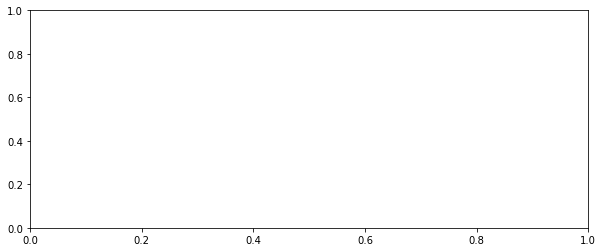

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(Ls_values*1e9, np.abs(z_thev_max_values1), label='Uniform spacing')
ax.plot(Ls_values*1e9, np.abs(z_thev_max_values2), label='Log-uniform spacing')
ax.plot(Ls_values*1e9, np.ones_like(Ls_values)*Rthev_target, label='Target')
ax.set_ylim(bottom=0)
ax.set_xlim(left=0)
ax.set_xlabel('$L_s$ (nH)')
ax.set_ylabel('Thévenin-equivalent Impedance ($\Omega$)')
ax.legend()
fig.tight_layout()

The highest Thévenin-equivalent impedance exceeds the target around 20 nH, so that seems like a good upper limit to set based on this.

### $L_s$ requirement from crosstalk

We'll calculate some values of nearest-neighbor crosstalk and make sure that the worst-crosstalking neighbors stay below the 0.3% we quoted in PTEP.

In [ ]:
### Old attempt to use Kolen's code:
# import sys
# sys.path.insert(0, '/Users/tijmen/litebird_codes/coscon-0.1.1/src') # Kolen's pypi package seems to be broken, so I'm just importing the source code manually
# from coscon import util
# #from coscon.toast_helper import CrosstalkMatrix
# R_TES = 0.6
# r_s = 0.3
# L = 60e-6
# L_com = 9e-9
# omega_min = 1.69e6 * (2.0 * np.pi)
# omega_max = 5.49e6 * (2.0 * np.pi)
# N = 68
# names = np.arange(N).astype('S')
# name = f'{N} detector crosstalk from SQUID paramters'
# omega = np.linspace(omega_min, omega_max, N)
# C_n_opt = util.C_n_resonance_exact(R_TES, r_s, L, L_com, omega)
# data = util.total_crosstalk_matrix_exact(R_TES, r_s, L, C_n_opt, L_com, omega)
# #m = CrosstalkMatrix(names, data, name=name, freq=(omega / (2.0 * np.pi)))
# #m.plot()    
### I abandoned this as it makes different circuit assumptions, but leaving it here in case it finds use somewhere else

Crosstalk for some bolometer $i$ is how much current response there is to a change in some other bolometer $j$'s resistance, compared to the response to a change in bolometer $i$'s resistance.

$\mathrm{xtalk}_{ij} = \frac{\partial I / \partial R_j}{\partial I / \partial R_i} = \frac{\partial Y / \partial R_j}{\partial Y / \partial R_i}$

Let's calculate this explicitly using a finite difference method.

In [ ]:
original_Ls1 = bolocomb1.Ls
original_Ls2 = bolocomb2.Ls
Ls_values = np.linspace(1e-9, 100e-9, 12)  # Range of Ls values
xtalk_target = 0.003 # Target of 0.3% as in PTEP

xtalk_max_values1 = np.zeros(len(Ls_values)) # In-phase component of highest-amplitude xtalk bolocomb1
xtalk_max_values2 = np.zeros(len(Ls_values)) # In-phase component of highest-amplitude xtalk bolocomb2
for i, Ls in enumerate(Ls_values):
    bolocomb1.Ls = Ls
    xtalk = bolocomb1.xtalk()
    whmax = np.argmax(np.abs(np.real(xtalk)))
    xtalk_max_values1[i] = np.real(xtalk[whmax])
    bolocomb2.Ls = Ls
    xtalk = bolocomb2.xtalk()
    whmax = np.argmax(np.abs(np.real(xtalk)))
    xtalk_max_values2[i] = np.real(xtalk[whmax])
bolocomb1.Ls = original_Ls1
bolocomb2.Ls = original_Ls2

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(Ls_values*1e9, xtalk_max_values1, label='Uniform spacing')
ax.plot(Ls_values*1e9, xtalk_max_values2, label='Log-uniform spacing')
ax.plot(Ls_values*1e9, np.ones_like(Ls_values)*xtalk_target, 'green', label='Target')
ax.plot(Ls_values*1e9, np.ones_like(Ls_values)*xtalk_target*-1, 'green')
ax.set_xlabel('$L_s$ (nH)')
ax.set_ylabel('In-phase crosstalk')
ax.legend()
fig.tight_layout()

The total crosstalk has two terms which have different phases (See Montgomery et al. 2020 for more details). The vector sum is such that lower common series inductance is not necessarily better for crosstalk. From this, it seems that in order to meet the crosstalk requirement, we should stay below about 60 nH. 

## Conclusions and caveats

I looked at a LiteBIRD-like DfMux comb using analytic expressions and numerical calculations. For this set of assumptions, I find that up to about 20 nH of common series inductance could be tolerated. This number is driven more strongly by concerns about the integrity of the voltage bias than by crosstalk concerns.

One caveat is that this conclusion holds fixed many of the unknown parameters of the LiteBIRD DfMux comb, and makes simplifying assumptions about the circuit. I recommend reserving significant contingency and designing for less than 20 nH at this stage of the design.

## Appendix

### Debugging / visualization

In [ ]:
(n_LCR, L, base_frequency, Rs, Rbias, Lbias, Ls, Cpar, Rpar, C, R) = (bolocomb1.n_LCR, bolocomb1.L, bolocomb1.base_frequency, bolocomb1.Rs, bolocomb1.Rbias, bolocomb1.Lbias, bolocomb1.Ls, bolocomb1.Cpar, bolocomb1.Rpar, bolocomb1.C, bolocomb1.R)
base_frequency=10 # just for debugging plots, run at finer resolution
Ls = 100e-9 # better illustration of "tuning out"
fmin = 1.5e6
fmax = 5.6e6
f = np.arange((fmin // base_frequency) * base_frequency, fmax, base_frequency)
f_z_thev_purely_real = np.zeros(n_LCR)
z_thev_optimal = np.zeros(n_LCR, dtype=np.complex64)
z_s_inv = 1./(Rs + Rbias + 2.j * np.pi * f * Lbias + 2.j * np.pi * f * Ls)
z_p_inv = 2.j * np.pi * f * Cpar + 1 / Rpar
z_p_inv_per_leg = 1./(2.j * np.pi * f[:, np.newaxis] * L + R + 1./(2.j * np.pi * f[:, np.newaxis] * C))

for i in range(n_LCR):
    this_z_p_inv = z_p_inv.copy()
    for j in range(n_LCR):
        if i != j:
            this_z_p_inv += z_p_inv_per_leg[:, j]
    this_z_LC = 2.j * np.pi * f * L + 1./(2.j * np.pi * f * C[i])
    this_z_thev = this_z_LC + 1./(z_s_inv + this_z_p_inv)
    wh_purely_real = np.argmin(np.abs(np.imag(this_z_thev)))
    z_thev_optimal[i] = this_z_thev[wh_purely_real]

In [ ]:
i = 65
this_z_p_inv = z_p_inv.copy()
for j in range(n_LCR):
    if i != j:
        this_z_p_inv += z_p_inv_per_leg[:, j]
this_z_LC = 2.j * np.pi * f * L + 1./(2.j * np.pi * f * C[i])
this_z_thev = this_z_LC + 1./(z_s_inv + this_z_p_inv)
wh_purely_real = np.argmin(np.abs(np.imag(this_z_thev)))
z_thev_optimal[i] = this_z_thev[wh_purely_real]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

colors = ['b', 'g', 'r', 'c', 'm']

# Main plot
ax.plot(f/1e6, np.abs(1./this_z_p_inv), '-', color=colors[0], label='$\mathrm{z_p}$')
ax.plot(f/1e6, np.abs(1./z_s_inv), '-', color=colors[1], label='$\mathrm{z_s}$')
ax.plot(f/1e6, np.abs(1./(z_s_inv + this_z_p_inv)), '-', color=colors[2], label='$\mathrm{z_s||z_p}$')
ax.plot(f/1e6, np.abs(this_z_LC), '-', color=colors[3], label='$\mathrm{z_{LC}}$')
ax.plot(f/1e6, np.abs(this_z_thev), '-', color=colors[4], label='$\mathrm{z_{Thév} = z_{LC} + z_s||z_p}$', linewidth=2)
ax.plot(f/1e6, np.real(1./this_z_p_inv), '--', color=colors[0])
ax.plot(f/1e6, np.real(1./z_s_inv), '--', color=colors[1])
ax.plot(f/1e6, np.real(1./(z_s_inv + this_z_p_inv)), '--', color=colors[2])
ax.plot(f/1e6, np.real(this_z_LC), '--', color=colors[3])
ax.plot(f/1e6, np.real(this_z_thev), '--', color=colors[4])
ax.plot(f/1e6, np.imag(1./this_z_p_inv), ':', color=colors[0])
ax.plot(f/1e6, np.imag(1./z_s_inv), ':', color=colors[1])
ax.plot(f/1e6, np.imag(1./(z_s_inv + this_z_p_inv)), ':', color=colors[2])
ax.plot(f/1e6, np.imag(this_z_LC), ':', color=colors[3])
ax.plot(f/1e6, np.imag(this_z_thev), ':', color=colors[4])

ax.set_ylim([0.05, 100])
ax.set_xlim([5.3, 5.5])
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Impedance ($\Omega$)')
ax.set_yscale('log')
ax.set_title('High-parasitic comb, uniform spacing: absolute (solid), real (dashed) and imaginary (dotted) parts', fontsize=10)

# Move the legend to the right-hand side
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('dfmux_comb_sim.pdf')
plt.savefig('dfmux_comb_sim.png', dpi=300)

plt.show()

In [ ]:
(n_LCR, L, base_frequency, Rs, Rbias, Lbias, Ls, Cpar, Rpar, C, R) = (bolocomb2.n_LCR, bolocomb2.L, bolocomb2.base_frequency, bolocomb2.Rs, bolocomb2.Rbias, bolocomb2.Lbias, bolocomb2.Ls, bolocomb2.Cpar, bolocomb2.Rpar, bolocomb2.C, bolocomb2.R)
base_frequency=10 # just for debugging plots, run at finer resolution
Ls = 100e-9 # better illustration of "tuning out"
fmin = 1.5e6
fmax = 5.6e6
f = np.arange((fmin // base_frequency) * base_frequency, fmax, base_frequency)
f_z_thev_purely_real = np.zeros(n_LCR)
z_thev_optimal = np.zeros(n_LCR, dtype=np.complex64)
z_s_inv = 1./(Rs + Rbias + 2.j * np.pi * f * Lbias + 2.j * np.pi * f * Ls)
z_p_inv = 2.j * np.pi * f * Cpar + 1 / Rpar
z_p_inv_per_leg = 1./(2.j * np.pi * f[:, np.newaxis] * L + R + 1./(2.j * np.pi * f[:, np.newaxis] * C))

for i in range(n_LCR):
    this_z_p_inv = z_p_inv.copy()
    for j in range(n_LCR):
        if i != j:
            this_z_p_inv += z_p_inv_per_leg[:, j]
    this_z_LC = 2.j * np.pi * f * L + 1./(2.j * np.pi * f * C[i])
    this_z_thev = this_z_LC + 1./(z_s_inv + this_z_p_inv)
    wh_purely_real = np.argmin(np.abs(np.imag(this_z_thev)))
    z_thev_optimal[i] = this_z_thev[wh_purely_real]

In [ ]:
i = 65
this_z_p_inv = z_p_inv.copy()
for j in range(n_LCR):
    if i != j:
        this_z_p_inv += z_p_inv_per_leg[:, j]
this_z_LC = 2.j * np.pi * f * L + 1./(2.j * np.pi * f * C[i])
this_z_thev = this_z_LC + 1./(z_s_inv + this_z_p_inv)
wh_purely_real = np.argmin(np.abs(np.imag(this_z_thev)))
z_thev_optimal[i] = this_z_thev[wh_purely_real]

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

colors = ['b', 'g', 'r', 'c', 'm']

# Main plot
ax.plot(f/1e6, np.abs(1./this_z_p_inv), '-', color=colors[0], label='$\mathrm{z_p}$')
ax.plot(f/1e6, np.abs(1./z_s_inv), '-', color=colors[1], label='$\mathrm{z_s}$')
ax.plot(f/1e6, np.abs(1./(z_s_inv + this_z_p_inv)), '-', color=colors[2], label='$\mathrm{z_s||z_p}$')
ax.plot(f/1e6, np.abs(this_z_LC), '-', color=colors[3], label='$\mathrm{z_{LC}}$')
ax.plot(f/1e6, np.abs(this_z_thev), '-', color=colors[4], label='$\mathrm{z_{Thév} = z_{LC} + z_s||z_p}$')
ax.plot(f/1e6, np.real(1./this_z_p_inv), '--', color=colors[0])
ax.plot(f/1e6, np.real(1./z_s_inv), '--', color=colors[1])
ax.plot(f/1e6, np.real(1./(z_s_inv + this_z_p_inv)), '--', color=colors[2])
ax.plot(f/1e6, np.real(this_z_LC), '--', color=colors[3])
ax.plot(f/1e6, np.real(this_z_thev), '--', color=colors[4])
ax.plot(f/1e6, np.imag(1./this_z_p_inv), ':', color=colors[0])
ax.plot(f/1e6, np.imag(1./z_s_inv), ':', color=colors[1])
ax.plot(f/1e6, np.imag(1./(z_s_inv + this_z_p_inv)), ':', color=colors[2])
ax.plot(f/1e6, np.imag(this_z_LC), ':', color=colors[3])
ax.plot(f/1e6, np.imag(this_z_thev), ':', color=colors[4])

ax.set_ylim([-100, 100])
ax.set_xlim([5.2, 5.4])
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Impedance ($\Omega$)')
ax.set_yscale('symlog', linthresh=0.01)
ax.set_title('LiteBIRD comb, log-uniform spacing: absolute (solid), real (dashed) and imaginary (dotted) parts', fontsize=10)

# Move the legend to the right-hand side
legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.savefig('dfmux_comb_sim.pdf')
plt.savefig('dfmux_comb_sim.png', dpi=300)


### Explore how parameters affect performance

In [ ]:
# Create two instances of the bolocomb class
bolocombA = bolocomb() # linear spacing
bolocombB = bolocomb() # linear spacing, some parameter modified

# Number of LCR legs in the comb
num_legs = 68

# Resistance values for both instances
R = 0.5 # all resistance values around 0.5 Ohms
R_values = np.ones(num_legs)*R
R_values += np.random.normal(0, 0.1, num_legs) * R # 10% scatter in R

# Inductance value (from the bolocomb class)
L_value = bolocombA.L

# For the first instance, create LCR legs uniformly distributed between 1.6 and 5.5 MHz
frequencies_uniform = np.linspace(1.6e6, 5.5e6, num_legs) + np.random.normal(0, 5e3, num_legs) # 1 sigma scatter of 5 kHz
C_values_uniform = 1 / ((2 * np.pi * frequencies_uniform) ** 2 * L_value)
bolocombA.C = C_values_uniform
bolocombA.R = R_values
bolocombB.C = C_values_uniform
bolocombB.R = R_values

bolocombA.Ls = 20e-9
bolocombB.Ls = 40e-9

z_thev1,_ = bolocombA.z_thev()
z_thev2,_ = bolocombB.z_thev()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(frequencies_uniform/1e6, np.real(z_thev1), label='Original parameters')
axs[0].plot(frequencies_uniform/1e6, np.real(z_thev2), label='Modified parameters')
Rthev_target = 0.1*bolocombA.R[0]  # Target of 10% of R
axs[0].plot(frequencies_uniform/1e6, np.ones_like(frequencies_uniform)*Rthev_target, label='Target')
axs[0].set_xlabel('Frequency (MHz)')
axs[0].legend()
axs[0].set_title('Thévenin-equivalent series impedance')
xtalk_target = 0.003 # Target of 0.3% as in PTEP
xtalk1 = bolocombA.xtalk()
xtalk2 = bolocombB.xtalk()
axs[1].plot(frequencies_uniform[0:-1]/1e6, np.real(xtalk1), label='Original parameters')
axs[1].plot(frequencies_uniform[0:-1]/1e6, np.real(xtalk2), label='Modified parameters')
axs[1].plot(frequencies_uniform/1e6, np.ones_like(frequencies_uniform)*xtalk_target, 'green', label='Target')
axs[1].plot(frequencies_uniform/1e6, np.ones_like(frequencies_uniform)*xtalk_target*-1, 'green')
axs[1].set_xlabel('Frequency (MHz)')
axs[1].legend()
axs[1].set_title('Crosstalk')
fig.tight_layout()

### Monte Carlo: vary many parameters simultaneously

Let's try varying many of the mux comb's parameters between limits that I consider somewhat reasonable / plausible.

In [ ]:
def random_bolocomb():
    this_bolocomb = bolocomb()
    num_legs = np.random.randint(58, 69) # number of LCR legs in the comb from 58 to 68 inclusive
    R = np.random.uniform(0.4, 1.0)  # all the same resistance values
    R_values = np.ones(num_legs) * R
    R_scatter = np.random.uniform(0, 0.2) # 0-20% scatter 
    R_values += np.random.normal(0, R_scatter, num_legs) * R

    # Inductance value (from the bolocomb class)
    L_value = this_bolocomb.L

    # Either choose log or linear uniform distribution of frequencies
    is_log = np.random.choice([True,False])
    min_frequency = np.random.uniform(1.6e6, 1.8e6)
    max_frequency = np.random.uniform(5.0e6, 5.6e6)
    frequency_scatter = np.random.uniform(1e3, 10e3) # scatter on the frequencies
    if is_log:
        frequencies = np.logspace(np.log10(min_frequency), np.log10(max_frequency), num_legs)
    else:
        frequencies = np.linspace(min_frequency, max_frequency, num_legs)
    
    frequencies += np.random.normal(0, frequency_scatter, num_legs)
    C_values = 1 / ((2 * np.pi * frequencies) ** 2 * L_value)
    this_bolocomb.C = C_values
    this_bolocomb.R = R_values

    this_bolocomb.Rs = np.random.exponential(0.005) # Stray series resistance in Ohms
    this_bolocomb.Ls = np.random.exponential(20e-9) # Stray series inductance in Henries
    this_bolocomb.Cpar = np.random.uniform(800e-12, 1500e-12) # Equivalent parasitic capacitance parallel to the comb in Farads
    this_bolocomb.Rpar = np.random.uniform(20,25) # Equivalent parasitic resistance parallel to the comb in Ohms
    this_bolocomb.Rbias = 0. # Bias resistor in Ohms, this is zero for LiteBIRD
    this_bolocomb.Lbias = np.random.uniform(3.8,5) * 1e-9 # Bias inductance in Henries
    return this_bolocomb

In [ ]:
plt.figure()
num_combs = 100
for i in range(num_combs):
    this_bolocomb = random_bolocomb()
    
    Rthev_target = 0.05 # 50 mOhm requirement
    z,_ = this_bolocomb.z_thev()
    wh_max = np.argmax(np.abs(z))
    z_thev = np.abs(z[wh_max])
    pass_thev = z_thev < Rthev_target

    xtalk_target = 3e-3
    max_xtalk = np.max(np.abs(np.real(this_bolocomb.xtalk())))
    pass_xtalk = max_xtalk < xtalk_target
    
    debug = True
    
    if pass_thev and pass_xtalk:
        if debug:
            print('😍😍 Both passed. The maximum Thévenin-equivalent series impedance was {} and the maximum in-phase crosstalk was {}'.format(z_thev,max_xtalk))
        color = 'green'
    elif pass_thev and not pass_xtalk:
        if debug:
            print('🤪 Failed because of xtalk. The maximum Thévenin-equivalent series impedance was {} and the maximum in-phase crosstalk was {}'.format(z_thev,max_xtalk))
        color = 'orange'
    elif not pass_thev and pass_xtalk:
        if debug:
            print('😵 Failed because of series impedance. The maximum Thévenin-equivalent series impedance was {} and the maximum in-phase crosstalk was {}'.format(z_thev,max_xtalk))
        color = 'blue'
    else: 
        if debug:
            print('🤬🤬🤬🤬 Both failed. The maximum Thévenin-equivalent series impedance was {} and the maximum in-phase crosstalk was {}'.format(z_thev,max_xtalk))
        color = 'red'

    plt.plot(np.median(this_bolocomb.R), this_bolocomb.Ls*1e9, marker='o', markersize=10, color=color)
legend_elements = [
    Line2D([0], [0], marker='o', color='green', markersize=10, label='both passed'),
    Line2D([0], [0], marker='o', color='orange', markersize=10, label='crosstalk failed'),
    Line2D([0], [0], marker='o', color='blue', markersize=10, label='series impedance failed'),
    Line2D([0], [0], marker='o', color='red', markersize=10, label='both failed'),
]
plt.legend(handles=legend_elements, loc='best')
plt.xlabel('Operating Resistance ($\Omega$)')
plt.ylabel('Common Series Inductance (nH)')        
plt.tight_layout()
plt.show()